# Data Science & Business Analytics Intern at The Sparks Foundation - GRIP APRIL'21 Batch
### Author: Sumit Mishra

##  TASK 5: Traffic sign Classification/Recognition system (Domain: Computer Vision & Internet of Things)

### Implement a real time traffic sign classifier which identifies the traffic sign and gives an alert.

### 1. Importing the required header files

In [ ]:
#importing the required pakages
import numpy as np
import pandas as pd
import random
import cv2
import os

import matplotlib.pyplot as plt
from imutils import paths
import imutils
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from skimage import transform
from skimage import exposure
from skimage import io

### 2. Reading and preparing the data

> Whole dataset can be found from below link.<br>
https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/

> About data<br>
* The given dataset is German Traffic Sign Benchmark dataset which is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011.
* The data has more than 40 classes with more than 50,000 images in total.

In [ ]:
#Reading Train.csv file

train_df = pd.read_csv("Train.csv")
print(train_df.shape)
train_df.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


* As we can see our dataset has 39209 training images and its 8 features.
* We will be using only ClassID and Path features, other columns can be ignored.

In [ ]:
#Reading Test.csv file

test_df = pd.read_csv("Test.csv")
print(test_df.shape)
test_df.head()

(12630, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


* As we can see our dataset has 12630 testing images and its 8 features.
* We will be using only ClassID and Path features, other columns can be ignored.

In [ ]:
#Reading signnames.csv file

label_df = pd.read_csv("signnames.csv")
print(label_df.shape)
label_df.head()

(43, 2)


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


* SignName column has the traffic sign name w.r.t ClassId.
* In this dataframe only unique ClassId's are present which are there in train & test dataframes.

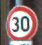

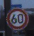

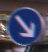

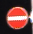

In [ ]:
#Here if we look at above few random images from our dataset,
#we can see images are in low resolution, and poor contrast.

Also our dataset is highly unbalanced as shown in below image.

<img src="https://pyimagesearch.com/wp-content/uploads/2019/11/traffic_sign_classification_distribution.png">

* So to solve this problem we have to do some image transformation and augmentation and also need to take care of class skewness.

In [ ]:
def prepare_data(root_dir, df):
  '''
  This function accepts the root directory path of dataset and
  dataframe containing path and class for train and test set
  and returns transformed images and their labels.
  '''
	data, labels = [], []
  #Shuffling the dataframe so that same class label won't be in a same order
	df = df.sample(frac=1)
    
	for i in range(df.shape[0]):
		#Picking label and image path from each row
		(label, path) = (df['ClassId'].values[i], df['Path'].values[i])
		#Deriving the full path to the image file and loading it for further processing
		image = io.imread(os.path.sep.join([root_dir, path]))
		#Resizing the image to be 32x32 pixels and then performing Contrast Limited Adaptive Histogram Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		#Updating the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))
  
	#Converting the data and labels list to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	return (data, labels)

In [ ]:
#Preparing train and test data

#Root directory containig all train and test data
root_dir = "gtsrb-german-traffic-sign/"

#Preparing the train and test data
(x_train, y_train) = prepare_data(root_dir, train_df)
(x_test, y_test) = prepare_data(root_dir, test_df)

#Scaling the data in the range of [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

#Doing one-hot encoding on class labels
num_unique_labels = len(np.unique(y_train))
y_train = to_categorical(y_train, num_unique_labels)
y_test = to_categorical(y_test, num_unique_labels)

#Loading the label names
label_names = list(label_df['SignName'].values)

### 3. Model Architecture

In [ ]:
#Initializing the sequential model
model = Sequential()
#(Conv2D => relu => BatchNormalization => MaxPooling2D),
#these set of layers with a 5×5 kernel will be used learn larger features.
#It will help to distinguish between different traffic sign shapes and color blobs on the traffic signs themselves.
model.add(Conv2D(8, (5, 5), padding="same", input_shape=(32, 32, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

#We will use 2 more sets of these layers twice  
#1st set of (Conv2D => relu => BatchNormalization) * 2 => MaxPooling2D
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
#2nd set of (Conv2D => relu => BatchNormalization) * 2 => MaxPooling2D
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

#We will use 2 sets of Fully-Connected layers as follows
#1st set of Fully-Connected layers with relu activation => BatchNormalization => Dropout
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#2nd set of Fully-Connected layers with relu activation => BatchNormalization => Dropout
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
		
#Softmax classifier
model.add(Dense(num_unique_labels))
model.add(Activation("softmax"))

#Summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 8)         608       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 16)       

### 4. Training the model

In [ ]:
#Initializing the number of epochs to train for, learning rate, and batch size.
n_epochs = 30
learning_rate = 1e-3
batch_size = 64

#Constructing the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.15, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.15, horizontal_flip=False,
                         vertical_flip=False, fill_mode="nearest")

#Compiling the model
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=learning_rate, decay=learning_rate / (n_epochs * 0.5)),
              metrics=["accuracy"])

#Fitting the model
history = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_test, y_test),
              steps_per_epoch=x_train.shape[0] // batch_size, epochs=n_epochs, verbose=2)

Epoch 1/30
612/612 - 26s - loss: 2.7128 - accuracy: 0.2868 - val_loss: 2.5674 - val_accuracy: 0.2832
Epoch 2/30
612/612 - 22s - loss: 1.4345 - accuracy: 0.5474 - val_loss: 0.7434 - val_accuracy: 0.7673
Epoch 3/30
612/612 - 21s - loss: 0.9822 - accuracy: 0.6885 - val_loss: 0.7190 - val_accuracy: 0.7793
Epoch 4/30
612/612 - 22s - loss: 0.7270 - accuracy: 0.7670 - val_loss: 0.4587 - val_accuracy: 0.8609
Epoch 5/30
612/612 - 22s - loss: 0.5722 - accuracy: 0.8161 - val_loss: 0.3534 - val_accuracy: 0.8903
Epoch 6/30
612/612 - 21s - loss: 0.4750 - accuracy: 0.8493 - val_loss: 0.4474 - val_accuracy: 0.8564
Epoch 7/30
612/612 - 22s - loss: 0.4114 - accuracy: 0.8670 - val_loss: 0.3421 - val_accuracy: 0.8945
Epoch 8/30
612/612 - 22s - loss: 0.3669 - accuracy: 0.8834 - val_loss: 0.3053 - val_accuracy: 0.9059
Epoch 9/30
612/612 - 22s - loss: 0.3264 - accuracy: 0.8957 - val_loss: 0.2698 - val_accuracy: 0.9196
Epoch 10/30
612/612 - 21s - loss: 0.3012 - accuracy: 0.9040 - val_loss: 0.3164 - val_accura

* As we can see we have achieved 95.86% of train and 93.17% of validation accuracy which is quite a good accuracy.
* Also there is not much difference between train accuracy/loss and validation accuracy/loss, that means our model is neither overfitting nor underfitting.

### 5. Evaluating the model

In [ ]:
#Evaluating the model

#Doing prediction on test set
pred = model.predict(x_test, batch_size=batch_size)

#Printing the classification report for test set
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=label_names))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.79      0.87      0.83        60
                              Speed limit (30km/h)       0.91      0.98      0.94       720
                              Speed limit (50km/h)       0.85      1.00      0.92       750
                              Speed limit (60km/h)       0.96      0.89      0.92       450
                              Speed limit (70km/h)       0.99      0.93      0.96       660
                              Speed limit (80km/h)       0.88      0.89      0.88       630
                       End of speed limit (80km/h)       0.92      0.87      0.89       150
                             Speed limit (100km/h)       0.93      0.96      0.95       450
                             Speed limit (120km/h)       0.96      0.93      0.94       450
                                        No passing       0.99      0.95      0.

* As we can see, for most of the classes we are getting very high precision and recall.
* But in some cases getting low but not too bad precision and recall, this is because of less training samples in that particular class.

### 6. Plotting the loss & accuracy of the model

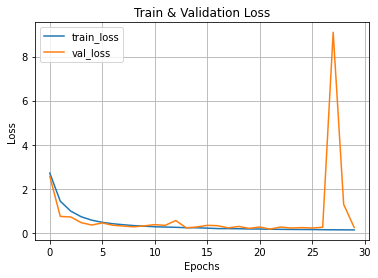

In [ ]:
#Plotting the train and validation loss
N = np.arange(0, 30)
plt.plot(N, loss, label="train_loss")
plt.plot(N, val_loss, label="val_loss")
plt.title("Train & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

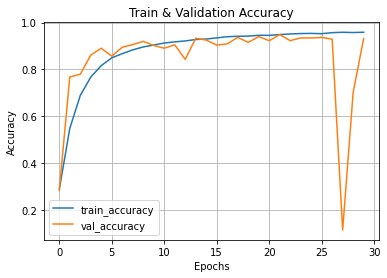

In [ ]:
#Plotting the train and validation accuracy
N = np.arange(0, 30)
plt.plot(N, acc, label="train_accuracy")
plt.plot(N, val_acc, label="val_accuracy")
plt.title("Train & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

### 7. Saving the model

In [ ]:
#Saving the model
model.save('saved_model.hdf5')

### 8. Testing the model on unseen test data

In [ ]:
#Loadig the model
model = load_model("saved_model.hdf5")

#Loading the label names
label_names = list(pd.read_csv('signnames.csv')['SignName'].values)

In [ ]:
def recognize_traffic_sign(path):
  '''
  This function accepts the image path and
  returns recognized traffic sign from that image.
  '''
  #Loading the image
  image = io.imread(path)
  #Resizing the image  to 32x32 pixels
  image = transform.resize(image, (32, 32))
  #Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
  image = exposure.equalize_adapthist(image, clip_limit=0.1)
	#Preprocessing the image by scaling it to the range [0, 1]
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)
	#Doing predictions using the trained traffic sign recognizer model
  preds = model.predict(image)
  j = preds.argmax(axis=1)[0]
  label = label_names[j]

	#Load the image using OpenCV, resize it, and draw the label on it
  image = cv2.imread(path)
  image = imutils.resize(image, width=128)
  cv2.putText(image, label, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
  cv2_imshow(image)
  print('Preicted/Recognized traffic sign:',label)

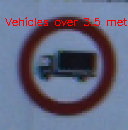

Preicted/Recognized traffic sign: Vehicles over 3.5 metric tons prohibited
--------------------------------------------------


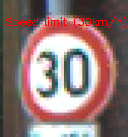

Preicted/Recognized traffic sign: Speed limit (30km/h)
--------------------------------------------------


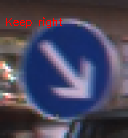

Preicted/Recognized traffic sign: Keep right
--------------------------------------------------


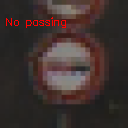

Preicted/Recognized traffic sign: No passing
--------------------------------------------------


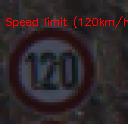

Preicted/Recognized traffic sign: Speed limit (120km/h)
--------------------------------------------------


In [ ]:
for i in np.array(os.listdir('Test'))[[2,5,7,25,37]]:
  recognize_traffic_sign('Test/'+i)
  print('-'*50)

* As we can observe, our model is doing pretty good recognition of traffic signs.
* Even for highly blurred and noisy images it is giving very much accurate predictions.

### 9. Conclusion

* For this task, I've collected data from kaggle datasets.
* We've build our own model architecture to solve this problem and we are able to achieve more than 95% of train and 93% of test accuracy.
* Even our model has high precision, recall and harmonic mean for most of the classes. In some case its near 60% due to imbalanced and less data.
* Our model is able to predict/recognize traffic sign from unseen highly blurred and noisy images.
* Now we can say, we have successfully built a model for traffic sign classification/recognition.